# Fitting the background

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pymc3
import pickle
import os

Lets read in the data

In [2]:
locs = np.genfromtxt('../locs.txt')
lo = locs.flatten().min() - 50.
hi = locs.flatten().max() + 50.

In [3]:
ff = np.genfromtxt('../freqs.txt')
pp = np.genfromtxt('../model.txt')
sel = (ff > lo) & (ff < hi)
f = ff[~sel]
p = pp[~sel]

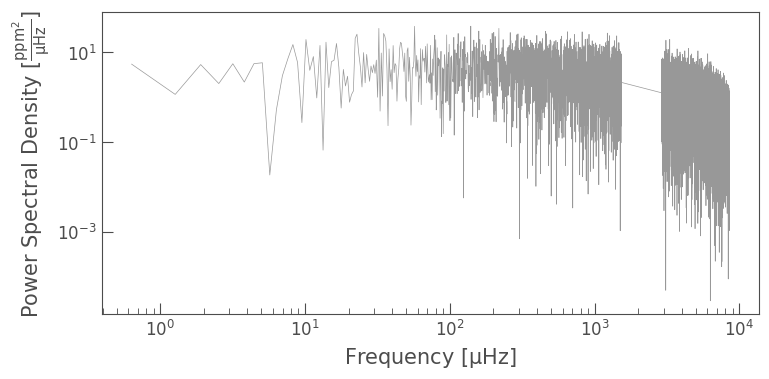

There are: 11295 datapoints


In [4]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5,scale='log')
plt.show()
print('There are: {} datapoints'.format(len(f)))

In [5]:
overwrite = True
backfit = '''
functions {
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
}
data {
    int N;
    vector[N] f;
    vector[N] p;
    real white_est;
    real nyq_est;
    real numax_est;
    real scale_spread;
}
parameters {
    real loga;
    real logb;
    real logc;
    real logd;
    real logj;
    real logk;
    real lognumax;
    real<lower=0> white;
    real<lower=0> nyq;
    real scale;
}
transformed parameters {
    real numax;

    numax = 10^lognumax;  
}
model {
    real a;
    real b;
    real c;
    real d;
    real j;
    real k;
    real beta[N];
    
    a = 10^loga;
    b = 10^logb;
    c = 10^logc;
    d = 10^logd;
    j = 10^logj;
    k = 10^logk;
    
    for (i in 1:N){
        beta[i] = 1. / (apod(f[i], nyq) * scale
                * (harvey(f[i], a, b, 4.0)
                + harvey(f[i], c, d, 4.0)
                + harvey(f[i], j, k, 2.0))
                + white);
        }
    p ~ gamma(1., beta);
    
    numax ~ normal(numax_est, numax_est*0.1);
    white ~ normal(white_est, white_est*0.3);
    nyq ~ normal(nyq_est, nyq_est*0.01);
    scale ~ normal(1, scale_spread);
    
    loga ~ normal(3.4 + lognumax *.48, 0.3);
    logb ~ normal(-0.43 + lognumax * 0.86, 0.3);
    logc ~ normal(3.59 + lognumax * -0.59, 0.3);
    logd ~ normal(0.02 + lognumax * 0.96, 0.3);
    logj ~ normal(loga-1, 1.2);
    logk ~ normal(logb-1, 0.2);
}
'''
model_path = 'backfit.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = backfit, model_name='backfit')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL backfit_e04ba166e396053244a2252e0e080b0c NOW.


Updating Stan model
Reading in Stan model


Guess the parameters

In [6]:
def guess(numax):
    ak, ae = 3.3, -0.48
    bk, be = -0.43, 0.86
    ck, ce = 3.59, -0.59
    dk, de = 0.02, 0.96

    a = 10**(ak + np.log10(numax)*ae)
    b = 10**(bk + np.log10(numax)*be)
    c = 10**(ck + np.log10(numax)*ce)
    d = 10**(dk + np.log10(numax)*de)
    j = a * 0.5
    k = b / 40.0
    scale = 1.0
    
    return [np.log10(a), np.log10(b), 
            np.log10(c), np.log10(d), 
            np.log10(j), np.log10(k), 
            np.log10(numax)]

In [7]:
numax = 2200
white = 1.
p0 = guess(numax)

data = {'N': len(f), 
        'f': f, 'p': p,
        'numax_est': numax, 'white_est': white,
        'nyq_est': np.max(f),
        'scale_spread': 0.01}

init = {'loga': p0[0], 'logb': p0[1], 
        'logc': p0[2], 'logd': p0[3],
        'logj': p0[4], 'logk': p0[5],
        'lognumax': p0[6],
        'white': white, 'nyq': np.max(f),
        'scale': 0.7}

In [8]:
nchains = 4
fit = sm.sampling(data=data, iter=100, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

In [9]:
print(fit)

Inference for Stan model: backfit_e04ba166e396053244a2252e0e080b0c.
4 chains, each with iter=100; warmup=50; thin=1; 
post-warmup draws per chain=50, total post-warmup draws=200.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
loga       1.89    0.04   0.13   1.74   1.79   1.81   2.06   2.08     10   1.74
logb       3.44    0.11   0.35    3.0   3.05   3.41   3.86   3.89     10   1.78
logc        1.8    0.13   0.43    0.6   1.54   2.07   2.08    2.1     11   1.43
logd        3.7    0.06   0.31   2.94   3.57   3.83   3.89   3.96     23   1.18
logj        1.4    0.16   0.59  -0.36   1.22   1.67    1.8   1.84     13   1.52
logk       2.58    0.11   0.38    1.7   2.31   2.71    2.9    3.0     12   1.55
lognumax   3.32  4.8e-3   0.05    3.2    3.3   3.33   3.36    3.4     95   1.03
white      0.11    0.01   0.05   0.02   0.07   0.11   0.15    0.2     14   1.19
nyq      8532.1    5.78  77.95 8369.3 8482.1 8540.9 8580.2 8695.3    182   1.02
scale       1.0  7.3

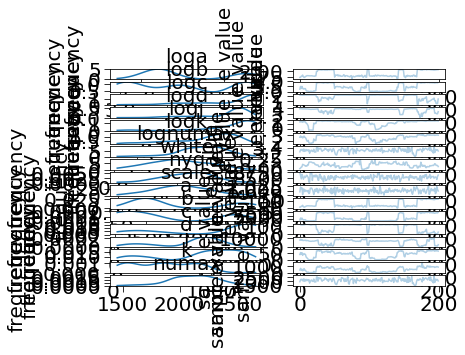

In [10]:
fit.plot()
plt.show()

In [11]:
a = 36.3                                                                
b = 723.52                                                              
c = 31.85                                                               
d = 2002.6                                                              
j = 1.79                                                                
k = 198.31                                                              
white = 0.09  
truths = [a, b, c, d, j, k, white, numax, 1., f[-1]]

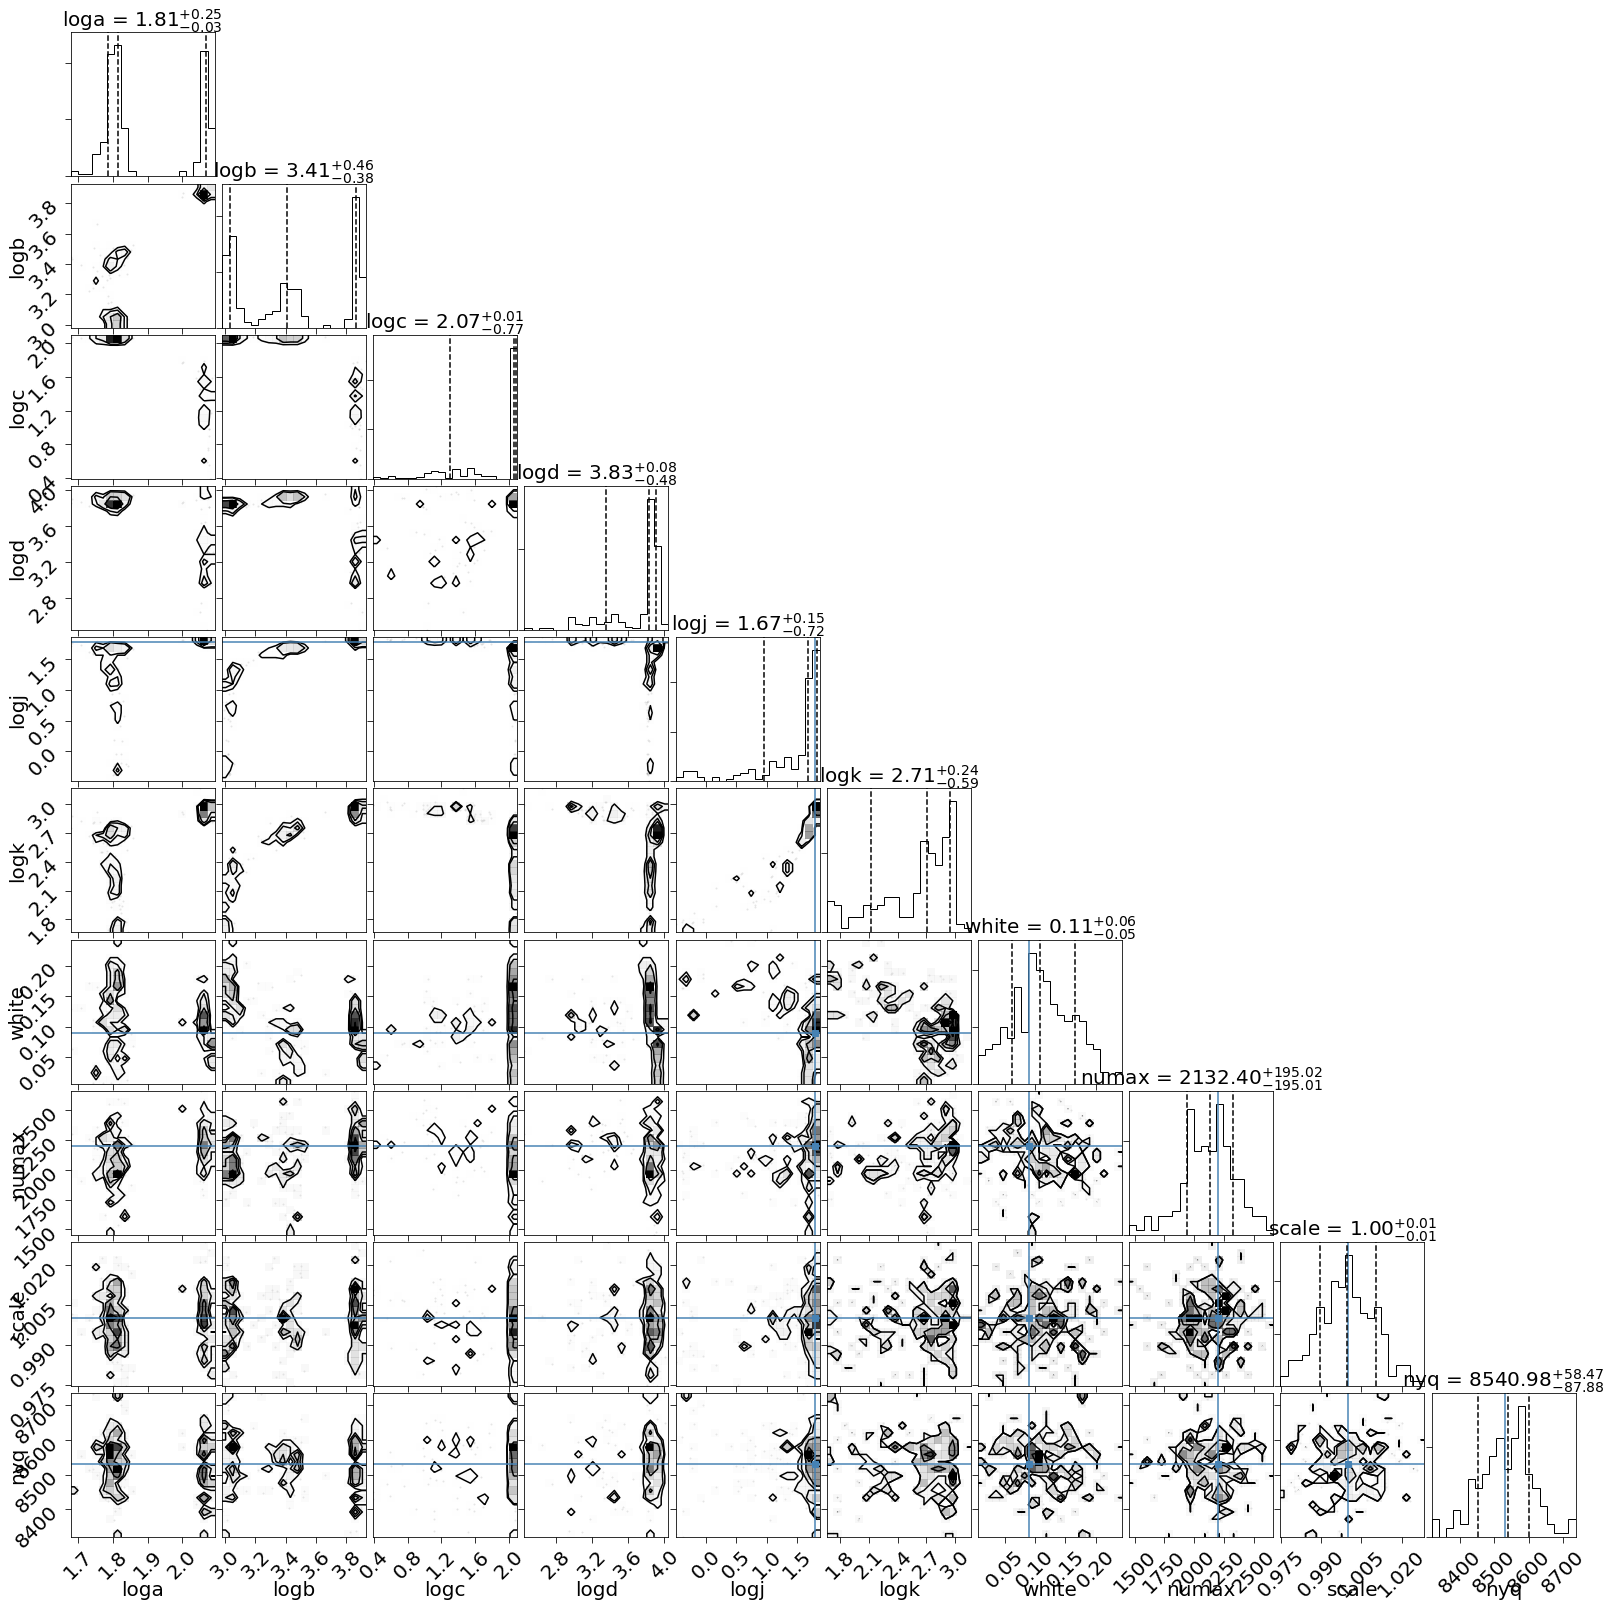

In [12]:
labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
chain = np.array([fit[label] for label in labels])
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[0.16, 0.5, 0.84],show_titles=True)
plt.show()

In [13]:
def harvey(f, a, b, c):
    #The harvey profile seems to take different forms depending on who I ask?
    #I'm going to be using the one used in Guy's BackFit code. Why is it different?
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);

    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, scale, nyq):
    #I did a fit to 16CygA using Guy's backfit program. I'm lifting the
    #Harvey components from there

    background = np.zeros(len(f))
    background += get_apodization(f, nyq)**2 * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

res = [np.median(fit[label]) for label in labels]
model = get_background(f, *res)

TypeError: get_background() takes 10 positional arguments but 11 were given

In [ ]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.25, label='Data', scale='log')
ax.plot(f, model, label='Model')
ax.plot(f, harvey(f, *res[0:2], 4.), label='Harvey 1', ls=':')
ax.plot(f, harvey(f, *res[2:4], 4.), label='Harvey 2', ls=':')
ax.plot(f, harvey(f, *res[4:6], 2.), label='Harvey 3', ls=':')
ax.plot(f, get_apodization(f, f[-1]), label='Apod', ls='--')
ax.plot(f, res[-3]*np.ones_like(f), label='white',ls='-.')
plt.legend(fontsize=10)